In this end-to-end ML project, data from [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk) competition will be used to build a classification model to predict a default. All steps of your typical Machine Learning project plan will be covered:

* Get Data and Define your problem
* Explore the data (EDA)
* Prepare data for modelling (Feature engineering and selection)
* Compare performance of several selected models
* Fine tune the selected model
* Present your solution (Interpretability)

# Importing data and libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.mad import MAD
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

The goal (problem needs to be solved) is to use all this data to build a model that can predict whether a given applicant is going to repay the loan ('good' customer) or default ('bad'). This type of models are used by banks and non-bank financial institutions to mitigate losses. Hence, that's quite interesting (and challenging) problem.

In [4]:
app_train=pd.read_csv('data/application_train.csv')
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,-3648.000,-2120,NaN,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188,-1186.000,-291,NaN,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,NaN,0.096,0.053,0.985,0.796,0.060,0.080,0.035,0.292,0.333,0.013,0.077,0.055,0.004,0.010,0.092,0.054,0.985,0.804,0.050,0.081,0.035,0.292,0.333,0.013,0.079,0.055,0.000,0.000,0.097,0.053,0.985,0.799,0.061,0.080,0.035,0.292,0.333,0.013,0.079,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,135000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010,-19046,-225,-4260.000,-2531,26.000,1,1,1,1,1,0,Laborers,1.000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.556,0.730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
app_train.shape

(307511, 122)

In [6]:
app_train.info(verbose=2, show_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

# EDA

## Column Types & Counts

Let's see how many columns of different types the dataset has

In [7]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

What about cardinality of categorical variables (how many unique values each of them has)?

In [8]:
app_train.select_dtypes('object').nunique().sort_values(ascending=False)

ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
CODE_GENDER                    3
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
dtype: int64

Default prediction is usually an imbalanced classification problem (as there are usually much less defaults than non-defaults)

In [9]:
app_train['TARGET'].value_counts(normalize=True)

0   0.919
1   0.081
Name: TARGET, dtype: float64

## Missing Values

Missing values can cause some problems during modelling. Several approaches can be used for handling them: dropping rows with NaNs entirely (the most basic and least optimal way), dropping columns with huge portion of NaNs, imputation (by mean, median, mode, special value), etc. One also could use models that can natively handle NaNs (KNN, tree-based models).

In [10]:
def miss_table(data):
    miss_table=data.isna().sum().to_frame(name='Count')
    miss_table['Percent']=miss_table['Count']/len(data)*100
    miss_table['Dtype']=data.dtypes[miss_table.index]
    miss_table['Count']=miss_table['Count'].replace({0: np.nan})
    miss_table=miss_table.dropna()
    print(f"There are {len(miss_table)}/{data.shape[1]} columns with missing values")
    print('Distribution by dtypes:')
    print(miss_table['Dtype'].value_counts())
    return miss_table.sort_values(by='Count', ascending=False)

mt=miss_table(app_train)
mt

There are 67/122 columns with missing values
Distribution by dtypes:
float64    61
object      6
Name: Dtype, dtype: int64


,Count,Percent,Dtype
COMMONAREA_MEDI,214865.000,69.872,float64
COMMONAREA_AVG,214865.000,69.872,float64
COMMONAREA_MODE,214865.000,69.872,float64
NONLIVINGAPARTMENTS_MEDI,213514.000,69.433,float64
NONLIVINGAPARTMENTS_MODE,213514.000,69.433,float64
NONLIVINGAPARTMENTS_AVG,213514.000,69.433,float64
FONDKAPREMONT_MODE,210295.000,68.386,object
LIVINGAPARTMENTS_MODE,210199.000,68.355,float64
LIVINGAPARTMENTS_MEDI,210199.000,68.355,float64
LIVINGAPARTMENTS_AVG,210199.000,68.355,float64


Lots of nulls in the data. Sometimes, missing value is not an error or data loss, but a marker that could separate a sample from others. Let's see whether default rates of samples with and without NaNs differ.

In [11]:
def default_missing(data, x, y='TARGET'):
    null_target=data.loc[app_train[x].isna(), y]
    null_target_mean=null_target.mean()*100
    not_null_target=data.loc[app_train[x].notna(), y]
    not_null_target_mean=not_null_target.mean()*100
    return [null_target.shape[0], not_null_target.shape[0], null_target_mean, not_null_target_mean]

In [12]:
missing_target_df=pd.DataFrame(columns=['Missing', 'Non Missing', 'Missing Default', 'Non Missing Default'])

for c in mt.index:
    missing_target_df.loc[c]=default_missing(app_train, c)
    
missing_target_df['Default Diff']=missing_target_df['Missing Default']-missing_target_df['Non Missing Default']

In [13]:
missing_target_df.sort_values(['Default Diff'], ascending=[False])

,Missing,Non Missing,Missing Default,Non Missing Default,Default Diff
AMT_REQ_CREDIT_BUREAU_DAY,41519.000,265992.000,10.337,7.719,2.618
AMT_REQ_CREDIT_BUREAU_QRT,41519.000,265992.000,10.337,7.719,2.618
AMT_REQ_CREDIT_BUREAU_HOUR,41519.000,265992.000,10.337,7.719,2.618
AMT_REQ_CREDIT_BUREAU_MON,41519.000,265992.000,10.337,7.719,2.618
AMT_REQ_CREDIT_BUREAU_WEEK,41519.000,265992.000,10.337,7.719,2.618
AMT_REQ_CREDIT_BUREAU_YEAR,41519.000,265992.000,10.337,7.719,2.618
EMERGENCYSTATE_MODE,145755.000,161756.000,9.261,7.003,2.258
TOTALAREA_MODE,148431.000,159080.000,9.234,6.990,2.244
ENTRANCES_MODE,154828.000,152683.000,9.179,6.952,2.227
ENTRANCES_AVG,154828.000,152683.000,9.179,6.952,2.227


So, there is clearly a difference in default rates here. A popular approach in credit scoring is [WOE transformation](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) of data and modelling with Logistic Regression. LogReg cannot handle NaNs on its own, but during WOE transformation step, missing values can be grouped in one bin and imputed with the computed WOE value. I'm going to use boosting algorithms, so they can handle missing values themselves (by choosing the node that results in minimal loss).

## Outliers

Another problem that lots of data scientists face is extremal values, outliers. Outliers can be a massive problem for ML models and can significantly decrease their performance. What you could do is drop outliers entirely, cap them, impute by mean/median, etc. Tree-based classification models are [not affected by them that much](https://datascience.stackexchange.com/questions/31434/handling-outliers-and-null-values-in-decision-tree). Also, note taht there can is a univariate and multivariate outlier detection. Refer to [PyOD docs](https://pyod.readthedocs.io/en/latest/) to learn how one can deal with them. There are dozens of various techniques.

Firstly look at summary statistics. Look for huge gaps between minimum, mean, and maximum

In [14]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000,307511.000,307511.000,307511.000,307511.000,307499.000,307233.000,307511.000,307511.000,307511.000,307511.000,307511.000,104582.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307509.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,134133.000,306851.000,246546.000,151450.000,127568.000,157504.000,103023.000,92646.000,143620.000,152683.000,154491.000,98869.000,124921.000,97312.000,153161.000,93997.000,137829.000,151450.000,127568.000,157504.000,103023.000,92646.000,143620.000,152683.000,154491.000,98869.000,124921.000,97312.000,153161.000,93997.000,137829.000,151450.000,127568.000,157504.000,103023.000,92646.000,143620.000,152683.000,154491.000,98869.000,124921.000,97312.000,153161.000,93997.000,137829.000,159080.000,306490.000,306490.000,306490.000,306490.000,307510.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,265992.000,265992.000,265992.000,265992.000,265992.000,265992.000
mean,278180.519,0.081,0.417,168797.919,599026.000,27108.574,538396.207,0.021,-16036.995,63815.046,-4986.120,-2994.202,12.061,1.000,0.820,0.199,0.998,0.281,0.057,2.153,2.052,2.032,12.063,0.015,0.051,0.041,0.078,0.230,0.180,0.502,0.514,0.511,0.117,0.088,0.978,0.752,0.045,0.079,0.150,0.226,0.232,0.066,0.101,0.107,0.009,0.028,0.114,0.088,0.977,0.760,0.043,0.074,0.145,0.222,0.228,0.065,0.106,0.106,0.008,0.027,0.118,0.088,0.978,0.756,0.045,0.078,0.149,0.226,0.232,0.067,0.102,0.109,0.009,0.028,0.103,1.422,0.143,1.405,0.100,-962.859,0.000,0.710,0.000,0.015,0.088,0.000,0.081,0.004,0.000,0.004,0.000,0.004,0.003,0.001,0.010,0.000,0.008,0.001,0.001,0.000,0.006,0.007,0.034,0.267,0.265,1.900
std,102790.175,0.272,0.722,237123.146,402490.777,14493.737,369446.461,0.014,4363.989,141275.767,3522.886,1509.450,11.945,0.002,0.384,0.400,0.043,0.450,0.231,0.911,0.509,0.503,3.266,0.122,0.220,0.197,0.268,0.421,0.384,0.211,0.191,0.195,

Some interesting values there are max(AMT_INCOME_TOTAL), max(AMT_REQ_CREDIT_BUREAU_QRT) and max(DAYS_EMPLOYED). The last one is actually impossimple (unless a vampire applied for a loan), it literally says that the person started current enployment 1000 years ago. Congrats, an error in the data is found. 

In [15]:
# impute by NaN, too much data to just drop
anomaly_ind=app_train[app_train['DAYS_EMPLOYED']==365243.000].index
print(f"{len(anomaly_ind)} out of {len(app_train)} ({len(anomaly_ind)/len(app_train) * 100:.2f}%) have invalid DAYS_EMPLOYED value")
print(f'Default rate for them is {100*app_train.loc[anomaly_ind, "TARGET"].mean():.2f}%. For others {100*app_train.drop(anomaly_ind)["TARGET"].mean():.2f}%')
app_train.loc[anomaly_ind, 'DAYS_EMPLOYED']=np.nan

55374 out of 307511 (18.01%) have invalid DAYS_EMPLOYED value
Default rate for them is 5.40%. For others 8.66%


One can also plot the features individually and observe outstanding parts. Not so reliable. Instead, one can use [MAD and modified Z-score](https://towardsdatascience.com/how-to-perform-univariate-outlier-detection-in-python-for-machine-learning-b9fb05e72661) or IQR method. These are one the most popular methods for univariate outlier detection ([for non-normally distributed variables](https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/insights_metrics_MODIFIED_Z_SCORE.html)). The simplest way to chech for normality is just to look at the distribution (although, [statistical tests](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/) are more reliable)

<ipython-input-16-9e51fa28bd5e>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 5, figsize=(18, 3))


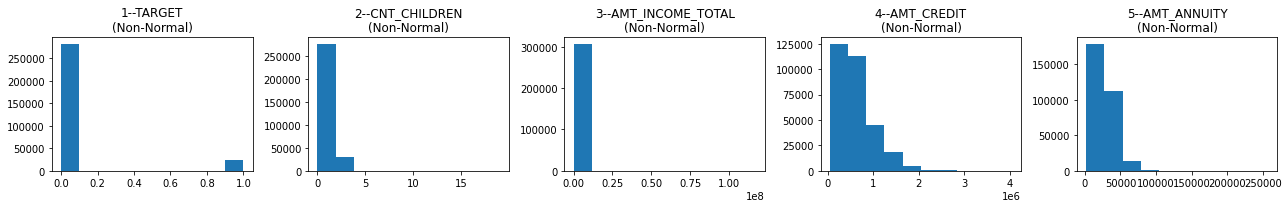

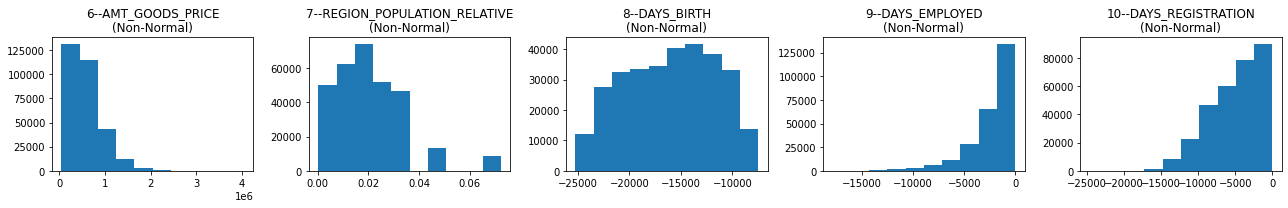

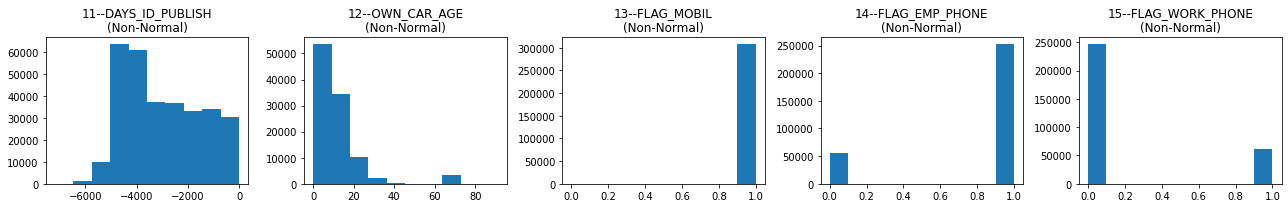

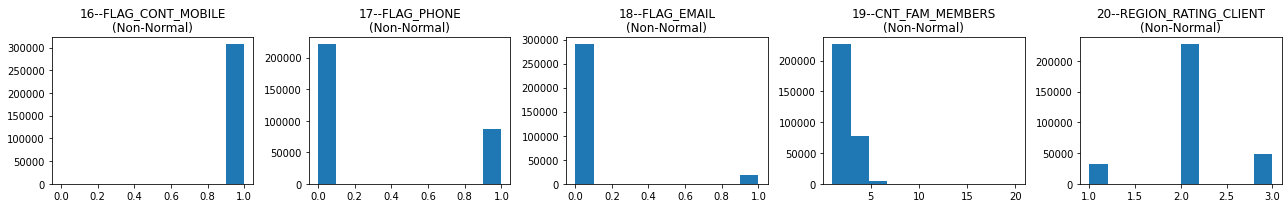

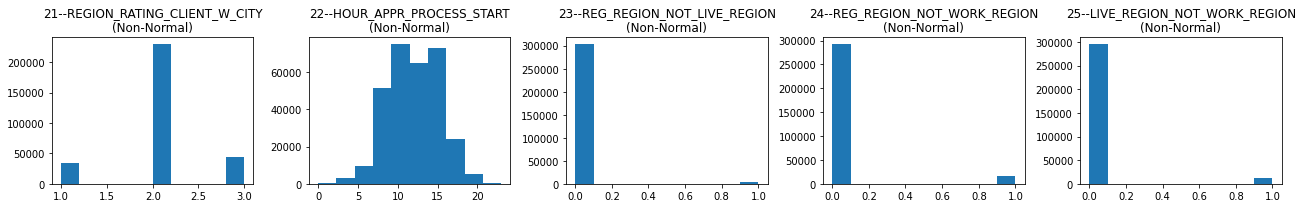

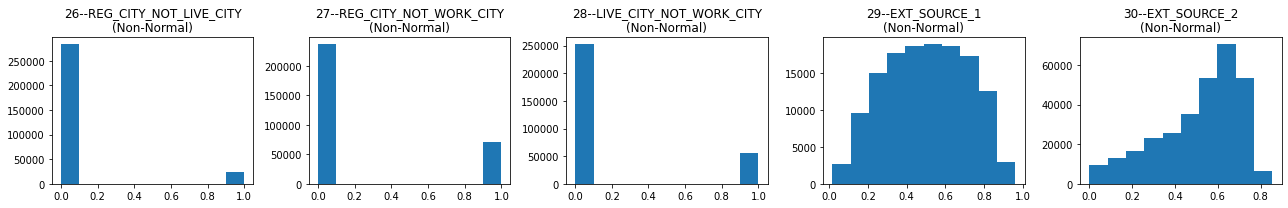

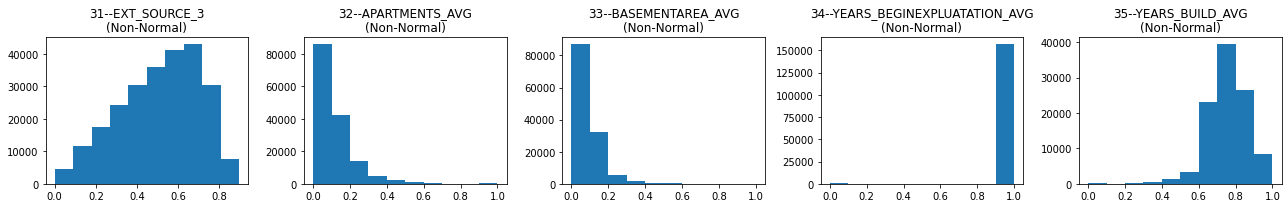

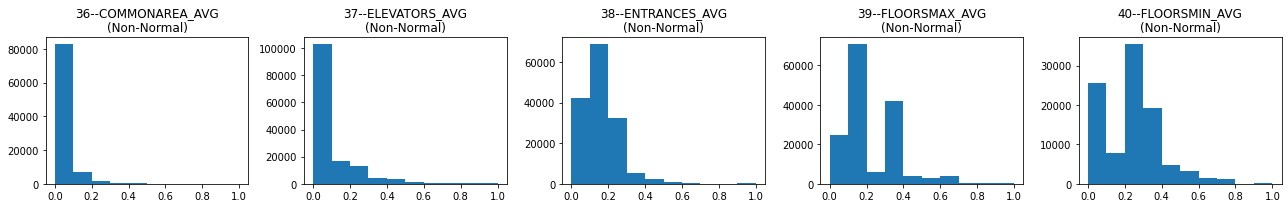

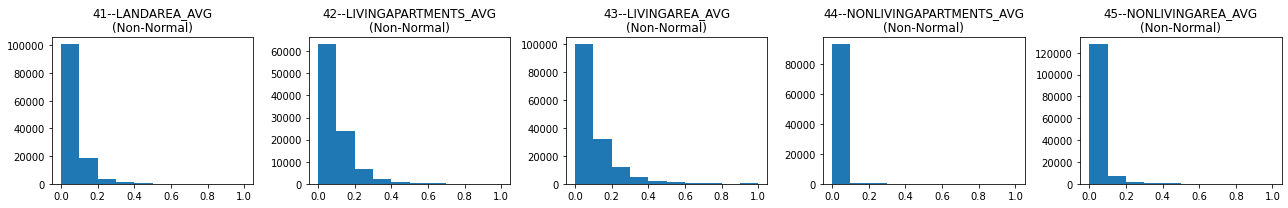

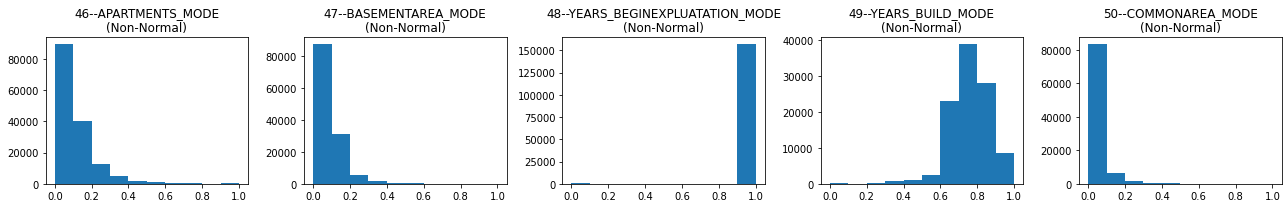

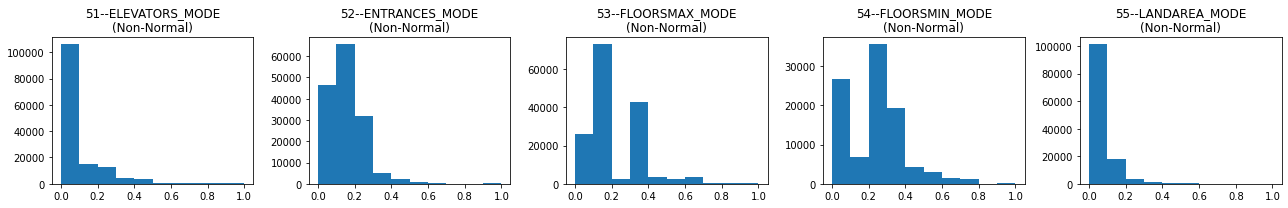

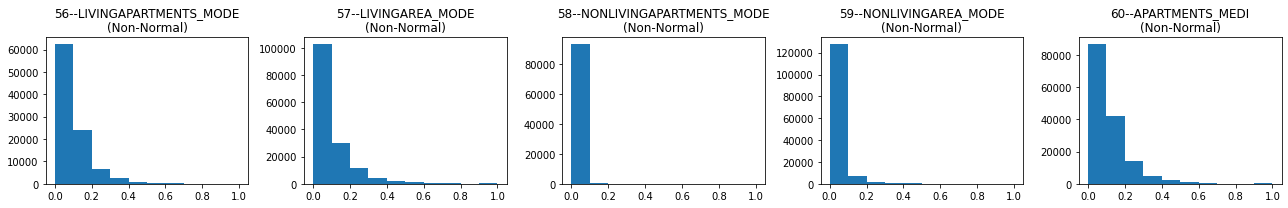

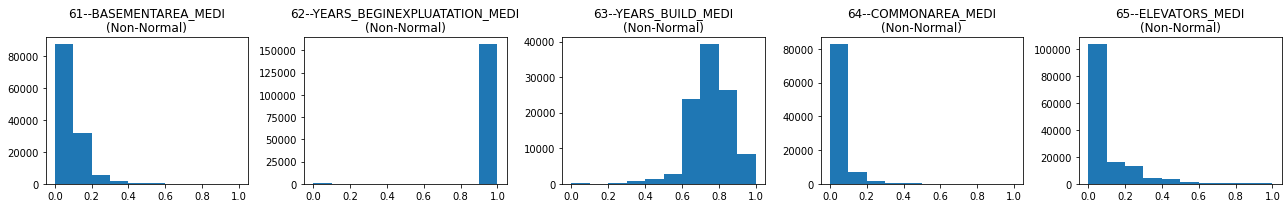

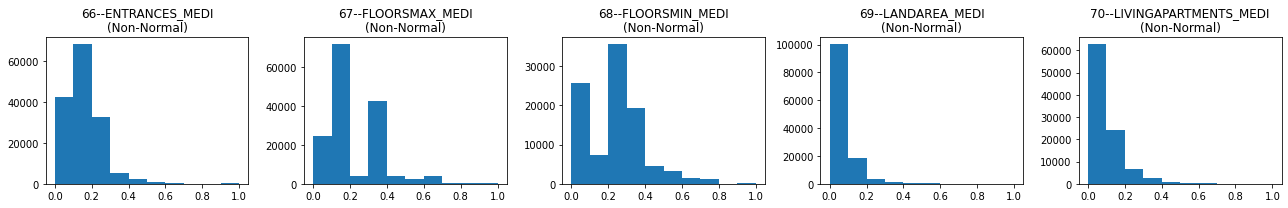

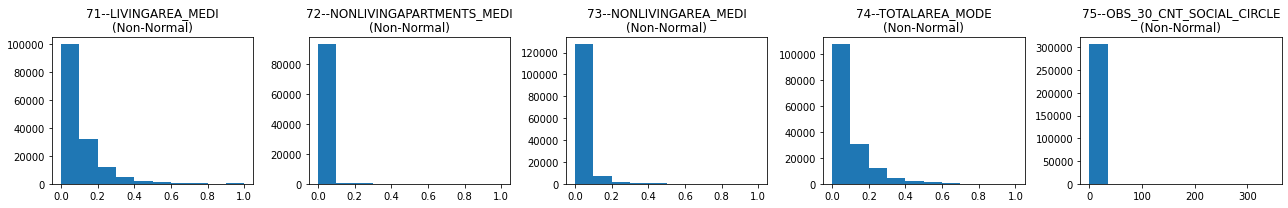

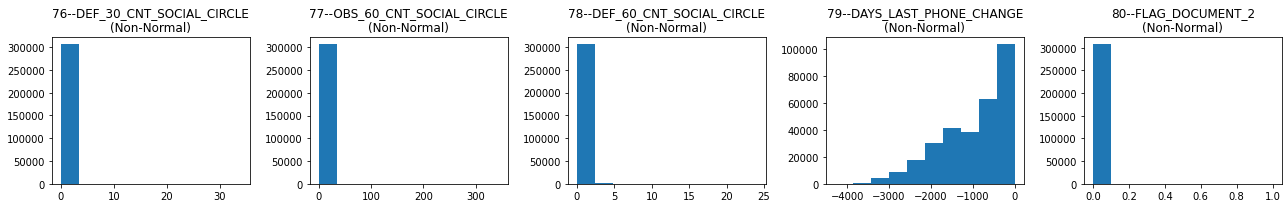

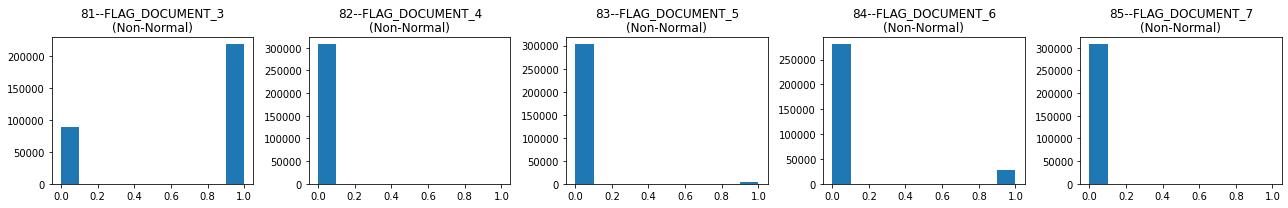

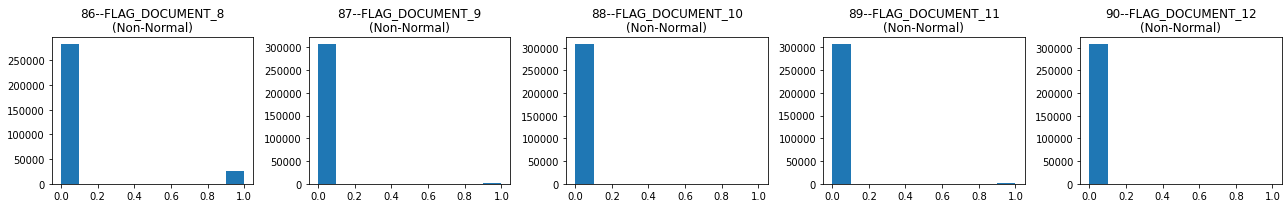

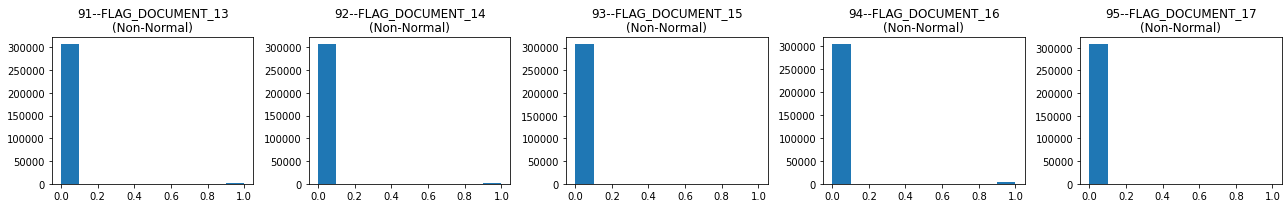

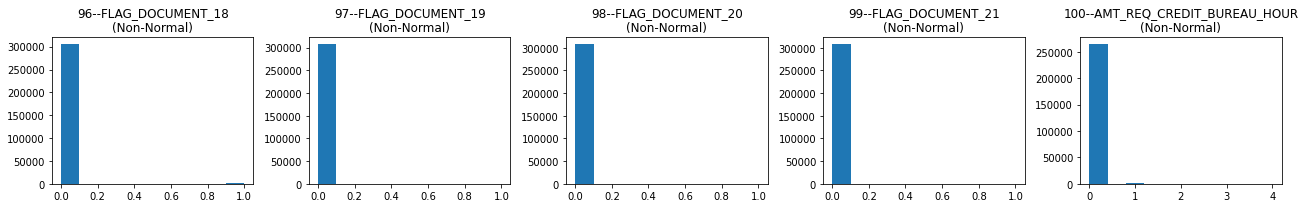

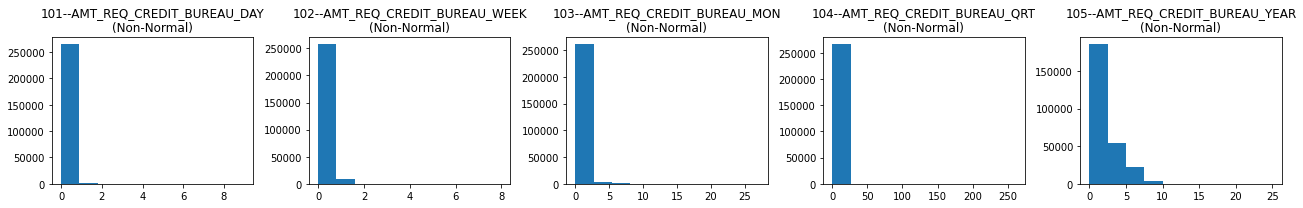

In [16]:
from scipy.stats import normaltest

cols=list(app_train.select_dtypes('number').columns[1:])

count=1
for c in range(0, int(np.ceil(len(cols)/5))):
    fig, axes = plt.subplots(1, 5, figsize=(18, 3))
    for i, ax in enumerate(axes.flat):
        if cols:
            col_name=cols.pop(0)
            ax.hist(app_train[col_name])
            stat, p=normaltest(app_train[col_name], nan_policy='omit')
            test_res='Non-Normal' if p<0.05 else 'Normal'
            ax.set_title(f'{count}--{col_name}\n({test_res})')
            fig.tight_layout()
            count+=1

Looks like there is no normal variables. Also, vast majority of variables are heavily skewed (because of some extreme values). Let's see how outliers affect distribution

AMT_INCOME_TOTAL: 9331 out of 307511 (3.03%) outliers


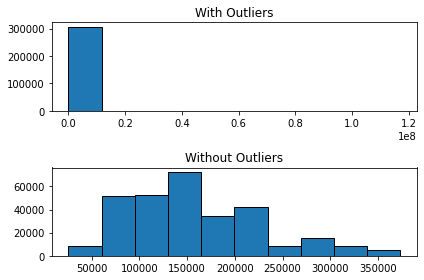

In [17]:
def find_outliers(data, x):
    mad_labels=MAD(threshold=3.5).fit(data[x].to_numpy().reshape(-1,1)).labels_
    print(f'{x}: {np.sum(mad_labels)} out of {len(data[x])} ({np.sum(mad_labels)/len(data[x]) *100:.2f}%) outliers')
    fig, axes=plt.subplots(2, 1, figsize=(6, 4))
    axes[0].hist(data[x], edgecolor='black', linewidth=1)
    axes[0].set_title('With Outliers')
    axes[1].hist(data[x][mad_labels==0], edgecolor='black', linewidth=1)
    axes[1].set_title('Without Outliers')
    fig.tight_layout()
    return mad_labels
    
labs=find_outliers(app_train, 'AMT_INCOME_TOTAL')

In [18]:
# https://stackoverflow.com/questions/59489073/how-to-not-remove-but-handle-outliers-by-transforming-using-pandas
# https://www.ibm.com/docs/el/cognos-analytics/11.1.0?topic=terms-modified-z-score
# Medcouples???

In [19]:
def modified_z_score(data, x):
    median_x=np.nanmedian(data[x])
    abs_diff=np.abs(data[x]-median_x)
    mad=np.nanmedian(abs_diff)
    if mad==0:
        mod_z_score=(data[x]-median_x)/(1.253314*np.mean(abs_diff))
    else:
        mod_z_score=(0.6745*(data[x]-median_x))/mad
        # IBM suggests using (data[x]-median_x)/(1.486*mad) here, other sources use 1st formula
    return median_x, mad, mod_z_score

_, _, mod_z=modified_z_score(app_train, 'AMT_INCOME_TOTAL')
(mod_z>3.5).sum()

9331

Comparison with PyOD's implementation

In [20]:
mad_labels=MAD(threshold=3.5).fit(app_train['AMT_INCOME_TOTAL'].to_numpy().reshape(-1,1)).labels_
mad_labels.sum()

9331

Instead of dropping outliers or imputing with mean/median, one could just cap/floor them: impute with max/min values from inliers.

In [21]:
def cap_outliers(data, x, tresh=3.5):
    series=data[x].copy()
    median, mad, mod_z_scores=modified_z_score(data, x)
    outliers=abs(mod_z_scores)>tresh
    max_cap, min_cap=series.loc[~outliers].max(), series.loc[~outliers].min()
    series.loc[mod_z_scores>tresh]=max_cap
    series.loc[mod_z_scores<tresh]=min_cap
    print(f'Lower bound: {median-tresh*mad}')
    print(f'Upper bound: {median+tresh*mad}')
    print(f'Capped {np.sum(outliers)} samples with max cap={max_cap} and min cap={min_cap}')
    return series

a=cap_outliers(app_train, 'AMT_INCOME_TOTAL')

Lower bound: -5625.0
Upper bound: 299925.0
Capped 9331 samples with max cap=373500.0 and min cap=25650.0


NOTE: This method is better than dropping outliers (although almost anything is better than that in most cases), but it's NOT a universal solution for outlier problem in data. In fact, there is probably no such solution.
\
Since tree models will be used later, I won't use capping, trimming, mean imputation, etc. But it's possible to experiment and compare models trained on capped and original data.

## Correlations

Let's examine how feaures correlate with our target. Also, dividing each feature into 2 groups by target and plotting these distributions can tell us how discriminative given features with regards to target.

In [22]:
corr_target=app_train.corr()['TARGET'].sort_values()

In [23]:
corr_target.head(10)

EXT_SOURCE_3                 -0.179
EXT_SOURCE_2                 -0.160
EXT_SOURCE_1                 -0.155
FLOORSMAX_AVG                -0.044
FLOORSMAX_MEDI               -0.044
FLOORSMAX_MODE               -0.043
AMT_GOODS_PRICE              -0.040
REGION_POPULATION_RELATIVE   -0.037
ELEVATORS_AVG                -0.034
ELEVATORS_MEDI               -0.034
Name: TARGET, dtype: float64

In [24]:
corr_target.tail(10)

REG_CITY_NOT_LIVE_CITY        0.044
FLAG_EMP_PHONE                0.046
REG_CITY_NOT_WORK_CITY        0.051
DAYS_ID_PUBLISH               0.051
DAYS_LAST_PHONE_CHANGE        0.055
REGION_RATING_CLIENT          0.059
REGION_RATING_CLIENT_W_CITY   0.061
DAYS_EMPLOYED                 0.075
DAYS_BIRTH                    0.078
TARGET                        1.000
Name: TARGET, dtype: float64

There is neither very strong positive nor negative correlations with target. Now let's plot these most correlated with target features 

In [25]:
selected_cols=list(corr_target.index[:10])+list(corr_target.index[-10:-1])

len(selected_cols)

19

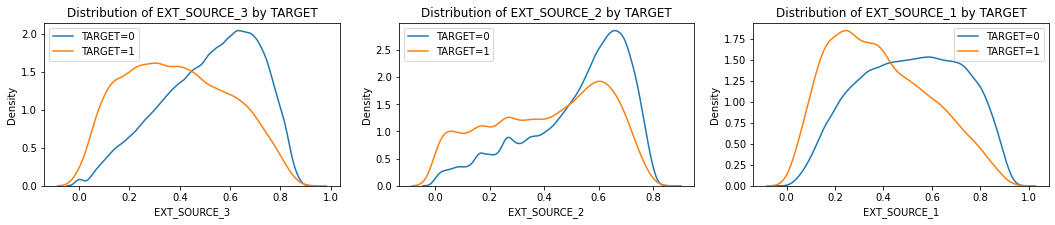

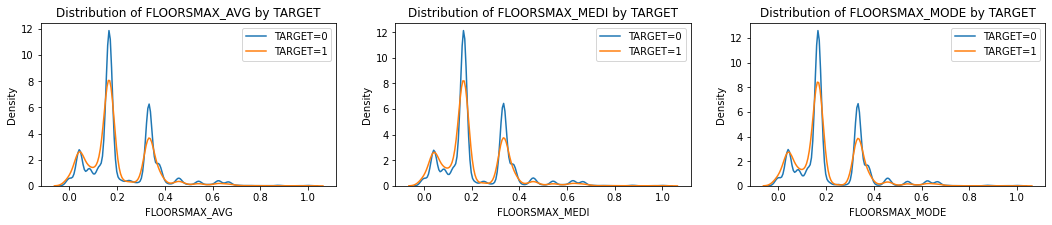

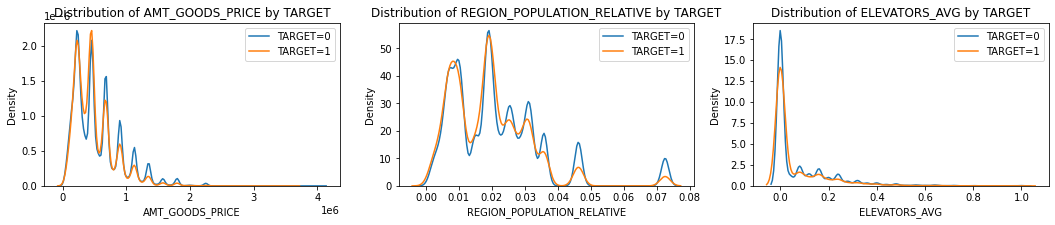

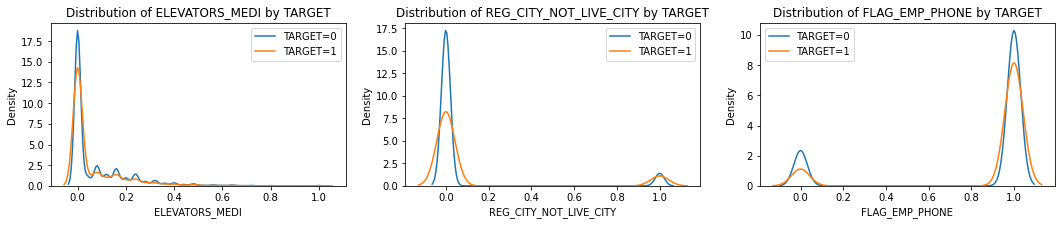

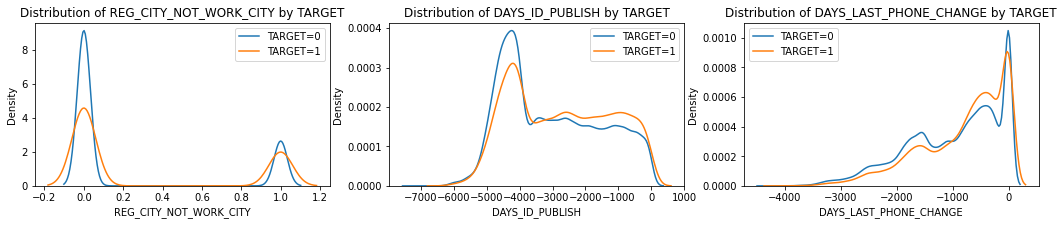

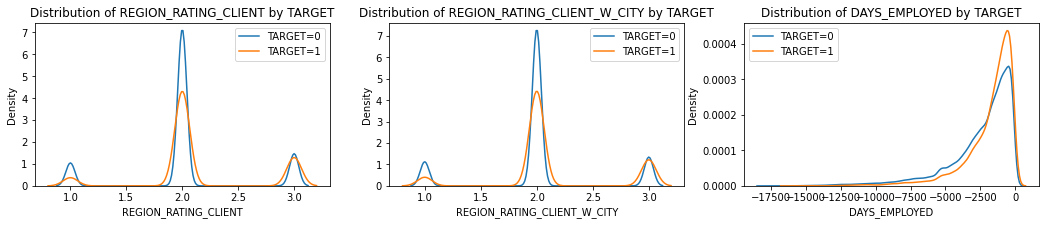

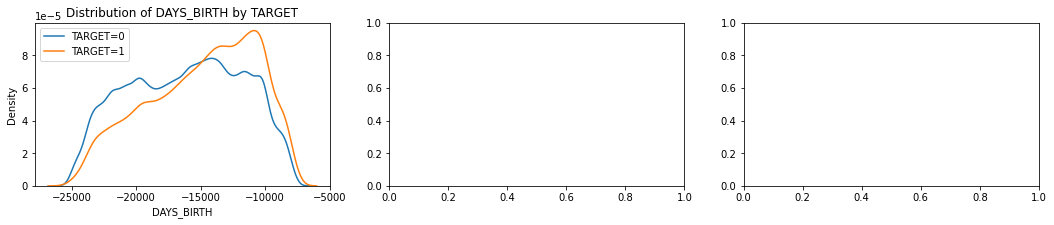

In [26]:
for c in range(0, int(np.ceil(len(selected_cols)/3))):
    fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    for i, ax in enumerate(axes.flat):
        if selected_cols:
            col_name=selected_cols.pop(0)
            sns.kdeplot(app_train.loc[app_train['TARGET']==0, col_name], label='TARGET=0', ax=ax)
            sns.kdeplot(app_train.loc[app_train['TARGET']==1, col_name], label='TARGET=1', ax=ax)
            ax.set_title(f'Distribution of {col_name} by TARGET')
            ax.legend()

Only 3 external_source variables and DAYS_BIRTH distributions are somewhat different. For example, in DAYS_BIRTH plot, we see that younger people are tend to default more. This difference can help models to distinguish defaults and non-defaults.

# Data Preparation

It's common knowledge that feature engineering is king. Hence, even if this part may be a bit tediuos and not as fun as building models, you probably won't be able to get a really great model without it. After FE (especially automatic FE), lots of new features will be added to the dataset. Obviously, not all of them will be useful in the model. So, we must do feature selection to keep 'best' features.

## Feature Engineering

Except for main `application_train.csv` file, there are 6 files with different data about an applicant. Hence, we can't ignore these files and must incorporate data from them too. But before that, let's create some domain knowledge-based features.

### Domain features

These are features that one thinks of because of some prior knowledge/experience in the area (you just know that they make sense, can help to distinquish good and bad applicants). Also there will be some features that are not knowledge-based, but just seems at least a bit promising. 

In [66]:
app_train['NAME_FAMILY_STATUS']

0         Single / not married
1                      Married
2         Single / not married
3               Civil marriage
4         Single / not married
                  ...         
307506               Separated
307507                   Widow
307508               Separated
307509                 Married
307510                 Married
Name: NAME_FAMILY_STATUS, Length: 307511, dtype: object

In [ ]:
cred_by_contract=app_train.groupby('NAME_CONTRACT_TYPE')['AMT_CREDIT'].mean() 
cred_by_housing_type=app_train.groupby('NAME_HOUSING_TYPE')['AMT_CREDIT'].mean() 
cred_by_org_type=app_train.groupby('ORGANIZATION_TYPE')['AMT_CREDIT'].mean() 
cred_by_education_type=app_train.groupby('NAME_EDUCATION_TYPE')['AMT_CREDIT'].mean() 
cred_by_gender=app_train.groupby('CODE_GENDER')['AMT_CREDIT'].mean() 
cred_by_family_status=app_train.groupby('NAME_FAMILY_STATUS')['AMT_CREDIT'].mean() 

inc_by_contract=app_train.groupby('NAME_CONTRACT_TYPE')['AMT_INCOME_TOTAL'].mean() 
inc_by_housing_type=app_train.groupby('NAME_HOUSING_TYPE')['AMT_INCOME_TOTAL'].mean() 
inc_by_org_type=app_train.groupby('ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].mean() 
inc_by_education_type=app_train.groupby('NAME_EDUCATION_TYPE')['AMT_INCOME_TOTAL'].mean() 
inc_by_gender=app_train.groupby('CODE_GENDER')['AMT_INCOME_TOTAL'].mean()
inc_by_family_status=app_train.groupby('NAME_FAMILY_STATUS')['AMT_INCOME_TOTAL'].mean() 

print(f'Before adding features: {app_train.shape}')

# CREDIT related 
app_train['NEW_AMT_CREDIT_TO_AMT_INCOME']=app_train['AMT_CREDIT']/app_train['AMT_INCOME_TOTAL'] 
app_train['NEW_AMT_CREDIT_TO_AMT_ANNUITY']=app_train['AMT_CREDIT']/app_train['AMT_ANNUITY']
app_train['NEW_AMT_CREDIT_TO_AMT_GOODS_PRICE']=app_train['AMT_CREDIT']/app_train['AMT_GOODS_PRICE']
app_train['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_CONTRACT_TYPE']=app_train['AMT_CREDIT']/(app_train['NAME_CONTRACT_TYPE'].map(cred_by_contract))
app_train['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_HOUSING_TYPE']=app_train['AMT_CREDIT']/(app_train['NAME_HOUSING_TYPE'].map(cred_by_housing_type))
app_train['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_ORGANIZATION_TYPE']=app_train['AMT_CREDIT']/(app_train['ORGANIZATION_TYPE'].map(cred_by_org_type))
app_train['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_EDUCATION_TYPE']=app_train['AMT_CREDIT']/(app_train['NAME_EDUCATION_TYPE'].map(cred_by_education_type))
app_train['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_GENDER']=app_train['AMT_CREDIT']/(app_train['CODE_GENDER'].map(cred_by_gender))
app_train['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_FAMILY_STATUS']=app_train['AMT_CREDIT']/(app_train['NAME_FAMILY_STATUS'].map(cred_by_family_status))


# INCOME related
app_train['NEW_INCOME_BY_CNT_CHILD']=app_train['AMT_INCOME_TOTAL']/(1+app_train['CNT_CHILDREN'])
app_train['NEW_INCOME_BY_CNT_FAM_MEMBERS']=app_train['AMT_INCOME_TOTAL']/app_train['CNT_FAM_MEMBERS']
app_train['NEW_INCOME_BY_AGE']=app_train['AMT_INCOME_TOTAL']/(app_train['DAYS_BIRTH']/-365)
app_train['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_CONTRACT_TYPE']=app_train['AMT_INCOME_TOTAL']/(app_train['NAME_CONTRACT_TYPE'].map(inc_by_contract))
app_train['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_HOUSING_TYPE']=app_train['AMT_INCOME_TOTAL']/(app_train['NAME_HOUSING_TYPE'].map(inc_by_housing_type))
app_train['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_ORGANIZATION_TYPE']=app_train['AMT_INCOME_TOTAL']/(app_train['ORGANIZATION_TYPE'].map(inc_by_org_type))
app_train['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_EDUCATION_TYPE']=app_train['AMT_INCOME_TOTAL']/(app_train['NAME_EDUCATION_TYPE'].map(inc_by_education_type))
app_train['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_GENDER']=app_train['AMT_INCOME_TOTAL']/(app_train['CODE_GENDER'].map(inc_by_gender))
app_train['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_FAMILY_STATUS']=app_train['AMT_CREDIT']/(app_train['NAME_FAMILY_STATUS'].map(inc_by_family_status))


# FLAG related
# doc_flags--20 columns about documents
# contact_flags--6 flags about contact info of client (FLAG_MOBIL, FLAG_EMAIL, etc)
doc_flags=[i for i in app_train.columns if 'FLAG_DOCUMENT' in i]
contact_flags=[i for i in app_train.columns if ('FLAG' in i) and (i not in doc_flags) and (i not in ('FLAG_OWN_CAR', 'FLAG_OWN_REALTY'))]
app_train['NEW_DOC_FLAG_MEAN']=app_train[doc_flags].mean(axis=1)
app_train['NEW_DOC_FLAG_SUM']=app_train[doc_flags].sum(axis=1)
app_train['NEW_CONTACT_FLAG_MEAN']=app_train[contact_flags].mean(axis=1)
app_train['NEW_CONTACT_FLAG_SUM']=app_train[contact_flags].sum(axis=1)


app_train['NEW_CNT_CHILD_TO_CNT_FAM_MEMBERS']=app_train['CNT_CHILDREN']/app_train['CNT_FAM_MEMBERS'] # number of kids to family members 
